In [1]:
import numpy as np
from scipy.sparse import diags, linalg, lil_matrix
import nibabel as nib
from scipy.interpolate import NearestNDInterpolator
from nilearn.plotting import plot_surf

In [30]:
def solve_laplace_beltrami_open_mesh(vertices, faces, boundary_conditions=None):
    """
    Solve the Laplace-Beltrami equation on a 3D open-faced surface mesh. No islands please!

    Parameters:
        vertices (np.ndarray): Array of shape (n_vertices, 3) containing vertex coordinates.
        faces (np.ndarray): Array of shape (n_faces, 3) containing indices of vertices forming each triangular face.
        boundary_conditions (dict, optional): Dictionary where keys are vertex indices with fixed values.

    Returns:
        solution (np.ndarray): Array of shape (n_vertices,) with the solution values.
    """

    n_vertices = vertices.shape[0]

    # Step 1: Compute cotangent weights
    weights = lil_matrix((n_vertices, n_vertices))
    for tri in faces:
        v0, v1, v2 = vertices[tri[0]], vertices[tri[1]], vertices[tri[2]]

        e0 = v1 - v2
        e1 = v2 - v0
        e2 = v0 - v1

        # Compute cross products and norms
        cross0 = np.cross(e1, -e2)
        cross1 = np.cross(e2, -e0)
        cross2 = np.cross(e0, -e1)

        norm0 = np.linalg.norm(cross0)
        norm1 = np.linalg.norm(cross1)
        norm2 = np.linalg.norm(cross2)

        # Avoid division by zero
        cot0 = np.dot(e1, -e2) / norm0 if norm0 > 1e-12 else 0.0
        cot1 = np.dot(e2, -e0) / norm1 if norm1 > 1e-12 else 0.0
        cot2 = np.dot(e0, -e1) / norm2 if norm2 > 1e-12 else 0.0

        weights[tri[0], tri[1]] += cot2 / 2
        weights[tri[1], tri[0]] += cot2 / 2

        weights[tri[1], tri[2]] += cot0 / 2
        weights[tri[2], tri[1]] += cot0 / 2

        weights[tri[2], tri[0]] += cot1 / 2
        weights[tri[0], tri[2]] += cot1 / 2

    weights = weights.tocsr()

    # Step 2: Handle boundaries for open meshes
    diagonal = weights.sum(axis=1).A1

    # Ensure no zero entries in diagonal to avoid singular matrix issues
    diagonal[diagonal < 1e-12] = 1e-12

    laplacian = diags(diagonal) - weights

    if boundary_conditions is None:
        boundary_conditions = {}

    boundary_indices = list(boundary_conditions.keys())
    boundary_values = np.array(list(boundary_conditions.values()))

    free_indices = np.setdiff1d(np.arange(n_vertices), boundary_indices)

    b = np.zeros(n_vertices)
    for idx, value in boundary_conditions.items():
        laplacian[idx, :] = 0
        laplacian[idx, idx] = 1
        b[idx] = value

    # Step 3: Solve the Laplace-Beltrami equation
    solution = np.zeros(n_vertices)

    if len(free_indices) > 0:
        free_laplacian = laplacian[free_indices][:, free_indices]
        free_b = b[free_indices] - laplacian[free_indices][:, boundary_indices] @ boundary_values

        solution[boundary_indices] = boundary_values
        try:
            solution[free_indices] = linalg.spsolve(free_laplacian, free_b)
        except linalg.MatrixRankWarning:
            print("Warning: Laplacian matrix is singular or ill-conditioned.")
            solution[free_indices] = np.zeros(len(free_indices))
    else:
        solution[boundary_indices] = boundary_values

    return solution


In [8]:
fn = '../hippunfold-wetrun/test-lowresMRI/tmp/sub-01/surf/sub-01_hemi-L_space-corobl_label-hipp_midthickness.surf.gii'
surf = nib.load(fn)
vertices = surf.agg_data('NIFTI_INTENT_POINTSET')
faces = surf.agg_data('NIFTI_INTENT_TRIANGLE')


In [27]:
from collections import defaultdict

def find_boundary_vertices(vertices, faces):
    """
    Find boundary vertices of a 3D mesh.

    Args:
        vertices (list of tuples): List of 3D points (x, y, z).
        faces (list of tuples): List of triangular faces, where each face
                                is a tuple of three vertex indices (v1, v2, v3).

    Returns:
        list: List of vertex indices that are boundary vertices, sorted in ascending order.
    """
    edge_count = defaultdict(int)

    # Step 1: Count edge occurrences
    for face in faces:
        # Extract edges from the face, ensure consistent ordering (min, max)
        edges = [
            tuple(sorted((face[0], face[1]))),
            tuple(sorted((face[1], face[2]))),
            tuple(sorted((face[2], face[0])))
        ]
        for edge in edges:
            edge_count[edge] += 1

    # Step 2: Identify boundary edges
    boundary_edges = [edge for edge, count in edge_count.items() if count == 1]

    # Step 3: Collect boundary vertices
    boundary_vertices = set()
    for edge in boundary_edges:
        boundary_vertices.update(edge)

    # Convert the set to a sorted list (array)
    return sorted(boundary_vertices)

boundary_vertices = find_boundary_vertices(vertices, faces)
len(boundary_vertices)

573

In [21]:
bounds = nib.load('../hippunfold-wetrun/test-lowresMRI/tmp/sub-01/anat/sub-01_hemi-L_space-corobl_desc-postproc_dseg.nii.gz')
bounds.affine

array([[ -0.30000001,   0.        ,   0.        ,  -2.30000591],
       [  0.        ,   0.30000001,   0.        , -51.10000229],
       [  0.        ,   0.        ,   0.30000001, -32.69999695],
       [  0.        ,   0.        ,   0.        ,   1.        ]])

In [28]:
prox = np.array(np.where(bounds.get_fdata()==3))
dist = np.array(np.where(bounds.get_fdata()==8))

# apply affine
prox = (bounds.affine @ np.vstack([prox, np.ones([1,prox.shape[1]])]))[:3,:]
dist = (bounds.affine @ np.vstack([dist, np.ones([1,dist.shape[1]])]))[:3,:]

interpol = NearestNDInterpolator(np.hstack([prox,dist]).T, np.hstack([np.zeros([prox.shape[1]]),np.ones([dist.shape[1]])]))
boundary_values = interpol(vertices[boundary_vertices,:])


In [31]:
boundary_conditions = dict(zip(boundary_vertices, boundary_values))
t = solve_laplace_beltrami_open_mesh(vertices,faces, boundary_conditions)

/export03/data/opt/venv/lib/python3.9/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [32]:
fn2 = '../hippunfold-wetrun/test-lowresMRI/tmp/sub-01/surf/sub-01_hemi-L_space-unfold_label-hipp_midthickness.surf.gii'

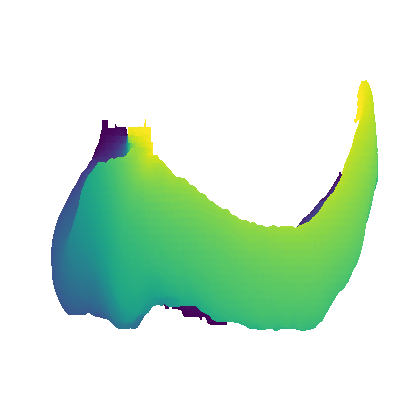

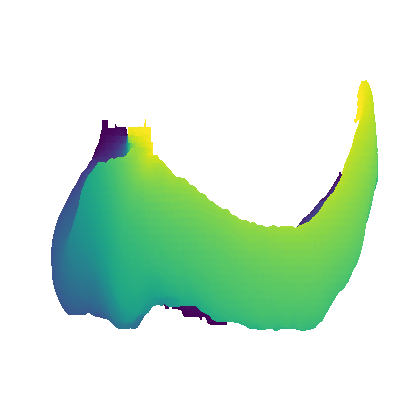

In [35]:
plot_surf(fn, t)

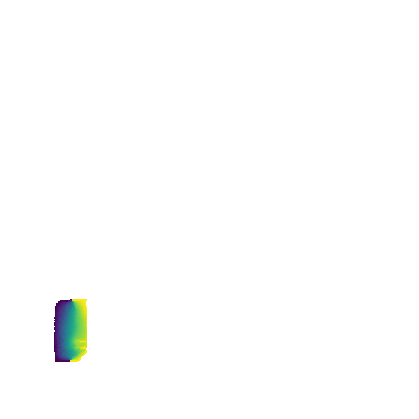

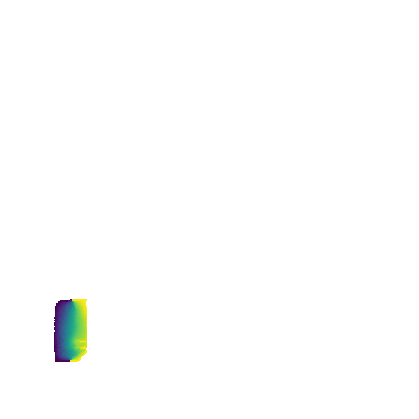

In [36]:
plot_surf(fn2, t, view='dorsal')